In [35]:
#importing libraries

import pandas as pd
import numpy as np
import wfdb
import ast
import os
from zlib import crc32
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [36]:
#loading the dataset
heart_data = pd.read_csv(r"C:\\Users\\user\\Desktop\\MYOCARDIAL DETECTION PROJECT\\DATASETS\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\\ptbxl_database.csv")
heart_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709,56,1,NaN,63.0,2.0,0.0,CS-12 E,09/11/1984 09:17,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243,19,0,NaN,70.0,2.0,0.0,CS-12 E,14/11/1984 12:55,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372,37,1,NaN,69.0,2.0,0.0,CS-12 E,15/11/1984 12:49,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014,24,0,NaN,82.0,2.0,0.0,CS-12 E,15/11/1984 13:44,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448,19,1,NaN,70.0,2.0,0.0,CS-12 E,17/11/1984 10:43,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [37]:
print(heart_data.columns)

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')


In [38]:
# Converting scp_codes string to dictionary
heart_data["scp_codes"] = heart_data["scp_codes"].apply(lambda x: ast.literal_eval(x))

In [39]:

# Paths
base_path = r"C:\Users\user\Desktop\MYOCARDIAL DETECTION PROJECT\DATASETS\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

# Load SCP mapping file
scp_mapping = pd.read_csv(f"{base_path}\\scp_statements.csv", index_col=0)

# Get all MI-related SCP codes
mi_codes = scp_mapping[scp_mapping['diagnostic_class'] == 'MI'].index.tolist()

# Ensure scp_codes column is in dictionary format
def parse_scp(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

heart_data["scp_codes"] = heart_data["scp_codes"].apply(parse_scp)

# Function to check if MI exists
def has_mi(scp_dict):
    return int(any(code in mi_codes for code in scp_dict.keys()))

# Create binary MI column
heart_data['MI'] = heart_data['scp_codes'].apply(has_mi)

# Check label distribution
print(heart_data['MI'].value_counts(normalize=True) * 100)


MI
0    74.911693
1    25.088307
Name: proportion, dtype: float64


In [40]:
# Hash function for deterministic splitting
def test_set_check(patientid, test_ratio):
    return crc32(np.int64(patientid)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_patient_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

def split_ecg_data(df, label_column, id_column="patient_id", 
                   test_ratio=0.3, val_ratio_within_temp=0.3333):

    # Hash split into train and temp (test+val)
    train_set, temp_set = split_train_test_by_patient_id(df, test_ratio, id_column)

    # Stratified split of temp into test and validation
    test_set, val_set = train_test_split(
        temp_set,
        test_size=val_ratio_within_temp,
        stratify=temp_set[label_column],
        random_state=42
    )
    
    # Report sizes & label balance
    print(f"Train: {len(train_set)} samples")
    print(f"Validation: {len(val_set)} samples")
    print(f"Test: {len(test_set)} samples")
    print("\nLabel distribution:")
    print("Train:\n", train_set[label_column].value_counts(normalize=True) * 100)
    print("Validation:\n", val_set[label_column].value_counts(normalize=True) * 100)
    print("Test:\n", test_set[label_column].value_counts(normalize=True) * 100)
    
    return train_set, val_set, test_set

train_set, val_set, test_set = split_ecg_data(
    heart_data,          
    label_column="MI",   
    id_column="patient_id",
    test_ratio=0.3,
    val_ratio_within_temp=0.3333
)


Train: 15259 samples
Validation: 2180 samples
Test: 4360 samples

Label distribution:
Train:
 MI
0    75.024576
1    24.975424
Name: proportion, dtype: float64
Validation:
 MI
0    74.633028
1    25.366972
Name: proportion, dtype: float64
Test:
 MI
0    74.655963
1    25.344037
Name: proportion, dtype: float64


In [41]:
#separating the features and target variable
target_col = "MI"
exclude_cols = ["MI", "scp_codes", "patient_id"]

X_train = train_set.drop(columns=exclude_cols)
y_train = train_set[target_col]

X_test = test_set.drop(columns=exclude_cols)
y_test = test_set[target_col]

X_val = val_set.drop(columns=exclude_cols)
y_val = val_set[target_col]

#verification
print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)
print("Validation:", X_val.shape, y_val.shape)

Shapes:
Train: (15259, 26) (15259,)
Test: (4360, 26) (4360,)
Validation: (2180, 26) (2180,)


In [42]:
#preprocessing the ecg features
from scipy.signal import butter, filtfilt, resample
path = r"C:\\Users\\user\\Desktop\\MYOCARDIAL DETECTION PROJECT\\DATASETS\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

# butterworth bandpass filter
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=100, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

#ECG Preprocessing: filter, normalize, selects leads, resamples ECG signals
def preprocess_ecg(signals, fs=100, target_length=None, leads=None):
    processed = []
    for ecg in signals:
        # Select leads if specified
        if leads is not None:
            ecg = ecg[:, leads]
            
        #Applying the bandpass filter to each lead
        ecg_filtered = np.array([bandpass_filter(lead, fs=fs) for lead in ecg.T]).T
        
        # Resample if target length is given
        if target_length is not None and ecg_filtered.shape[0] != target_length:
            ecg_filtered = resample(ecg_filtered, target_length, axis=0)
        
        # Normalize each lead separately
        ecg_norm = (ecg_filtered - np.mean(ecg_filtered, axis=0)) / np.std(ecg_filtered, axis=0)
        
        processed.append(ecg_norm)
    
    processed = np.array(processed)
    # Reshape for CNN: (samples, timesteps, channels)
    return processed    


In [43]:
#loading ECG waveforms and preprocess

def load_and_preprocess(df, sampling_rate, base_path, target_length, selected_leads):
    if sampling_rate == 100:
        signals = [wfdb.rdsamp(f"{base_path}\\{fname}")[0] for fname in df["filename_lr"]]
    else:
        signals = [wfdb.rdsamp(f"{base_path}\\{fname}")[0] for fname in df["filename_hr"]]

    X_processed = preprocess_ecg(signals, fs=sampling_rate, target_length=target_length, leads=selected_leads)
    y_labels = df["MI"].values
    return X_processed, y_labels


#parameters
sampling_rate = 100  # change to 500 for high resolution
target_length = 1000 # resample all to 1000 timesteps
selected_leads = None # e.g., [0] for Lead I only, None for all leads

X_train, y_train = load_and_preprocess(train_set, sampling_rate, path, target_length, selected_leads)
X_test, y_test   = load_and_preprocess(test_set, sampling_rate, path, target_length, selected_leads)
X_val, y_val     = load_and_preprocess(val_set, sampling_rate, path, target_length, selected_leads)


#Output Shapes for DL

print("ECG waveform shapes (ready for CNN):")
print("Train:", X_train.shape, "Labels:", y_train.shape)
print("Test:", X_test.shape, "Labels:", y_test.shape)
print("Validation:", X_val.shape, "Labels:", y_val.shape)

C:\Users\user\AppData\Local\Temp\ipykernel_23960\3394831394.py:29: RuntimeWarning: invalid value encountered in divide
  ecg_norm = (ecg_filtered - np.mean(ecg_filtered, axis=0)) / np.std(ecg_filtered, axis=0)


ECG waveform shapes (ready for CNN):
Train: (15259, 1000, 12) Labels: (15259,)
Test: (4360, 1000, 12) Labels: (4360,)
Validation: (2180, 1000, 12) Labels: (2180,)


In [44]:
#saving the preprocessing pipeline
save_dir = "preprocessed_ecg"
os.makedirs(save_dir, exist_ok=True)

np.savez(os.path.join(save_dir, "train.npz"), X=X_train, y=y_train)
np.savez(os.path.join(save_dir, "test.npz"), X=X_test, y=y_test)
np.savez(os.path.join(save_dir, "val.npz"), X=X_val, y=y_val)

print(f"✅ Saved preprocessed data to '{save_dir}'")

✅ Saved preprocessed data to 'preprocessed_ecg'


In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import metrics

# CNN architecture
def build_cnn(input_shape):
    model = models.Sequential([
        layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),

        layers.Conv1D(64, kernel_size=5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),

        layers.Conv1D(128, kernel_size=5, activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Binary classification: MI or not
    ])
    return model

# Build model
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, leads)
model = build_cnn(input_shape)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        metrics.AUC(name="auc"),
        metrics.Precision(name="precision"),
        metrics.Recall(name="recall")
    ]
)

# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_cnn_model.keras", save_best_only=True, monitor='val_accuracy', mode='max'
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True, monitor='val_accuracy', mode='max'
)

# Train model with validation set
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1
)

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 50s 171ms/step - accuracy: 0.8306 - auc: 0.8644 - loss: 0.3825 - precision: 0.6971 - recall: 0.5689 - val_accuracy: 0.7922 - val_auc: 0.9089 - val_loss: 0.4691 - val_precision: 0.9032 - val_recall: 0.2025
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - accuracy: 0.8600 - auc: 0.9047 - loss: 0.3243 - precision: 0.7625 - recall: 0.6379 - val_accuracy: 0.8509 - val_auc: 0.9238 - val_loss: 0.3452 - val_precision: 0.8631 - val_recall: 0.4901
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 38s 159ms/step - accuracy: 0.8714 - auc: 0.9193 - loss: 0.2997 - precision: 0.7835 - recall: 0.6704 - val_accuracy: 0.8706 - val_auc: 0.9266 - val_loss: 0.3232 - val_precision: 0.8538 - val_recall: 0.5913
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 38s 160ms/step - accuracy: 0.8781 - auc: 0.9274 - loss: 0.2844 - precision: 0.7934 - recall: 0.6922 - val_accuracy: 0.8748 - val_auc: 0.9299 - val_loss: 0.3048 - val_precision: 0.8256 - val_recall: 0.6420
Epoch 5/30
239/239 ━

Validation Metrics:
loss: 0.2829
compile_metrics: 0.8867


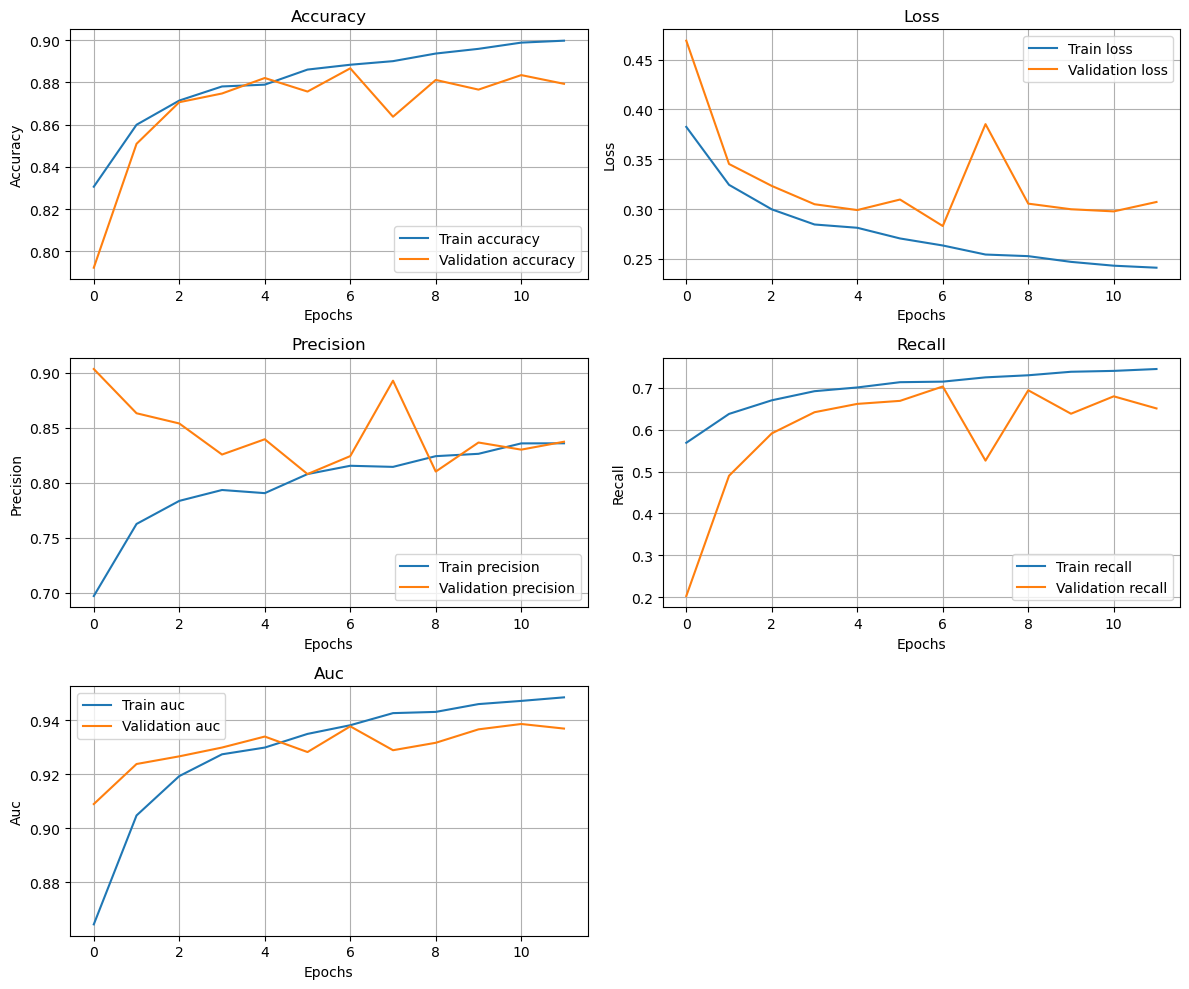

In [46]:
#evaluating the model on the validation set
val_results = model.evaluate(X_val, y_val, verbose=0)
val_metrics = dict(zip(model.metrics_names, val_results))

print("Validation Metrics:")
for name, value in val_metrics.items():
    print(f"{name}: {value:.4f}")

#visualizing the results 
def plot_metrics(history):
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    plt.figure(figsize=(12, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i + 1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metrics(history)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.9040    0.9490    0.9259      1627
           1     0.8242    0.7034    0.7590       553

    accuracy                         0.8867      2180
   macro avg     0.8641    0.8262    0.8425      2180
weighted avg     0.8837    0.8867    0.8836      2180


 Confusion Matrix (Validation Set):
[[1544   83]
 [ 164  389]]


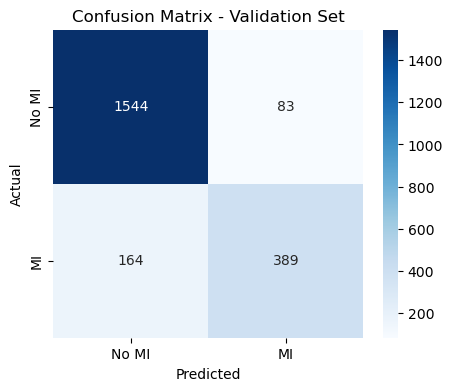

In [47]:
#checking other metrics

# Predict probabilities
y_val_probs = model.predict(X_val)

# Default threshold = 0.5
y_val_pred = (y_val_probs >= 0.5).astype(int)

# Classification report
print("\n Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("\n Confusion Matrix (Validation Set):")
print(cm)

# Confusion matrix plot
import seaborn as sns


plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No MI", "MI"],
            yticklabels=["No MI", "MI"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Set")
plt.show()


Class Weights: {0: 0.6664482879105521, 1: 2.0019679874048806}
Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - accuracy: 0.8695 - auc: 0.9379 - loss: 0.3186 - precision: 0.6939 - recall: 0.8544 - val_accuracy: 0.8656 - val_auc: 0.9381 - val_loss: 0.3038 - val_precision: 0.6964 - val_recall: 0.8336
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - accuracy: 0.8640 - auc: 0.9410 - loss: 0.3097 - precision: 0.6792 - recall: 0.8633 - val_accuracy: 0.8651 - val_auc: 0.9369 - val_loss: 0.3042 - val_precision: 0.6942 - val_recall: 0.8373
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - accuracy: 0.8716 - auc: 0.9451 - loss: 0.2995 - precision: 0.6928 - recall: 0.8727 - val_accuracy: 0.8862 - val_auc: 0.9382 - val_loss: 0.2816 - val_precision: 0.7808 - val_recall: 0.7667
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - accuracy: 0.8736 - auc: 0.9475 - loss: 0.2926 - precision: 0.6952 - recall: 0.8798 - val_accuracy: 0.8835 - val_auc: 0.9352 - val_loss: 0.2955 - v

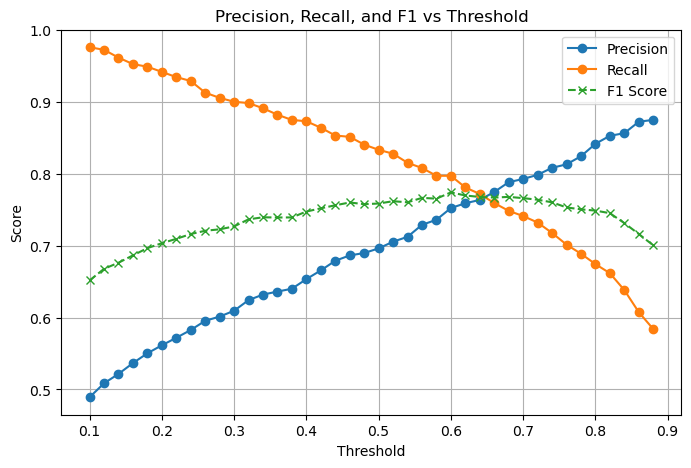


 Suggested threshold based on recall priority: 0.10
✅ Using threshold for inference: 0.10

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.9879    0.6533    0.7865      1627
           1     0.4891    0.9765    0.6518       553

    accuracy                         0.7353      2180
   macro avg     0.7385    0.8149    0.7192      2180
weighted avg     0.8614    0.7353    0.7524      2180


Confusion Matrix (Validation Set):
[[1063  564]
 [  13  540]]


In [48]:
#hyperparameter tuning for the model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Compute class weights

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights_dict = dict(zip(classes, class_weights))
print("Class Weights:", class_weights_dict)


#  Train model with class weights

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint_cb, earlystop_cb],
    class_weight=class_weights_dict,
    verbose=1
)


# Threshold tuning

y_val_probs = model.predict(X_val)

thresholds = np.arange(0.1, 0.9, 0.02)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred_thresh = (y_val_probs >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_thresh, zero_division=0))
    f1s.append(f1_score(y_val, y_pred_thresh, zero_division=0))

    # Print current threshold metrics
    print(f"Threshold: {t:.2f} | Precision: {precisions[-1]:.4f} | Recall: {recalls[-1]:.4f} | F1: {f1s[-1]:.4f}")

# Plot Precision–Recall vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label="Precision", marker='o')
plt.plot(thresholds, recalls, label="Recall", marker='o')
plt.plot(thresholds, f1s, label="F1 Score", linestyle='--', marker='x')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 vs Threshold")
plt.grid(True)
plt.legend()
plt.show()


# Pick best threshold (recall priority)

best_threshold = thresholds[np.argmax(recalls)]
print(f"\n Suggested threshold based on recall priority: {best_threshold:.2f}")

# Manual override
THRESHOLD = best_threshold  # Change manually if needed
print(f"✅ Using threshold for inference: {THRESHOLD:.2f}")


# Evaluation with chosen threshold

y_val_pred_best = (y_val_probs >= THRESHOLD).astype(int)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred_best, digits=4))

print("\nConfusion Matrix (Validation Set):")
print(confusion_matrix(y_val, y_val_pred_best))


# Inference function using threshold

def predict_ecg(model, ecg_sample, threshold=THRESHOLD):
    """
    Predicts MI (1) or No MI (0) for a single ECG sample using the given threshold.
    ecg_sample: shape (timesteps, leads)
    """
    prob = model.predict(np.expand_dims(ecg_sample, axis=0))[0][0]
    label = int(prob >= threshold)
    return label, prob


In [49]:
#manual selection of a threshold
THRESHOLD = 0.26

print(f" Using threshold for inference: {THRESHOLD:.2f}")

# Evaluation with chosen threshold

y_val_pred_best = (y_val_probs >= THRESHOLD).astype(int)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred_best, digits=4))

print("\nConfusion Matrix (Validation Set):")
print(confusion_matrix(y_val, y_val_pred_best))


 Using threshold for inference: 0.26

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.9640    0.7892    0.8679      1627
           1     0.5955    0.9132    0.7209       553

    accuracy                         0.8206      2180
   macro avg     0.7797    0.8512    0.7944      2180
weighted avg     0.8705    0.8206    0.8306      2180


Confusion Matrix (Validation Set):
[[1284  343]
 [  48  505]]


In [50]:
#evaluating the model on the test set

y_test_probs = model.predict(X_test, verbose=1)
y_test_pred = (y_test_probs >= THRESHOLD).astype(int)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, digits=4))

print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))


137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step

Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9596    0.7810    0.8611      3255
           1     0.5833    0.9032    0.7088      1105

    accuracy                         0.8119      4360
   macro avg     0.7714    0.8421    0.7850      4360
weighted avg     0.8642    0.8119    0.8225      4360


Confusion Matrix (Test Set):
[[2542  713]
 [ 107  998]]


HYPERPARAMETER TUNING (ECG AUGMENTATION)

In [51]:
# EC augmentation to simulate real world conditions
import numpy as np
from scipy.signal import resample

def add_gaussian_noise(ecg, noise_std=0.02):
    return ecg + noise_std * np.random.randn(*ecg.shape)

def time_stretch(ecg, min_factor=0.95, max_factor=1.05):
    length = ecg.shape[0]
    factor = np.random.uniform(min_factor, max_factor)
    new_length = max(1, int(length * factor))
    stretched = resample(ecg, new_length, axis=0)
    if new_length > length:
        return stretched[:length]
    elif new_length < length:
        pad_len = length - new_length
        return np.pad(stretched, ((0, pad_len), (0, 0)), mode='edge')
    else:
        return stretched

def amplitude_scale(ecg, min_scale=0.9, max_scale=1.1):
    scale = np.random.uniform(min_scale, max_scale)
    return ecg * scale

def baseline_wander(ecg, fs=100, min_freq=0.2, max_freq=0.6, max_amp=0.02):
    t = np.arange(ecg.shape[0]) / fs
    freq = np.random.uniform(min_freq, max_freq)
    amp = np.random.uniform(0.0, max_amp)
    drift = amp * np.sin(2 * np.pi * freq * t)
    return ecg + drift[:, np.newaxis]

def augment_single(ecg, fs=100):
    ecg_aug = add_gaussian_noise(ecg, noise_std=np.random.uniform(0.005, 0.03))
    ecg_aug = time_stretch(ecg_aug, min_factor=0.96, max_factor=1.04)
    ecg_aug = amplitude_scale(ecg_aug, min_scale=0.92, max_scale=1.08)
    if np.random.rand() < 0.5:
        ecg_aug = baseline_wander(ecg_aug, fs=fs, min_freq=0.2, max_freq=0.6, max_amp=0.02)
    return ecg_aug


# Balanced batch generator
import math

def balanced_batch_generator(X, y, batch_size=64, pos_fraction=0.5, augment_fn=augment_single, fs=100, shuffle=True):
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    if len(pos_idx) == 0 or len(neg_idx) == 0:
        raise ValueError("Need both positive and negative samples.")
        
    n_pos_batch = int(round(batch_size * pos_fraction))
    n_neg_batch = batch_size - n_pos_batch
    
    steps_per_epoch = math.ceil(len(neg_idx) / max(1, n_neg_batch))
    
    while True:
        if shuffle:
            np.random.shuffle(pos_idx)
            np.random.shuffle(neg_idx)
        for start in range(0, len(neg_idx), n_neg_batch):
            neg_batch_idx = neg_idx[start:start + n_neg_batch]
            if len(neg_batch_idx) < n_neg_batch:
                extra = np.random.choice(neg_idx, size=n_neg_batch - len(neg_batch_idx), replace=True)
                neg_batch_idx = np.concatenate([neg_batch_idx, extra])
            pos_batch_idx = np.random.choice(pos_idx, size=n_pos_batch, replace=True)
            X_neg = X[neg_batch_idx]
            y_neg = y[neg_batch_idx]
            X_pos = np.stack([augment_fn(X[i], fs=fs) for i in pos_batch_idx], axis=0)
            y_pos = np.ones(len(pos_batch_idx), dtype=y.dtype)
            X_batch = np.concatenate([X_neg, X_pos], axis=0)
            y_batch = np.concatenate([y_neg, y_pos], axis=0)
            perm = np.random.permutation(len(X_batch))
            yield X_batch[perm], y_batch[perm]


In [52]:
#building the CNN
def build_cnn(input_shape):
    return models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(32, kernel_size=5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),
        layers.Conv1D(64, kernel_size=5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),
        layers.Conv1D(128, kernel_size=5, activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])


In [53]:
#Training both the Basline (no augmentation) and the augmented model
#Baseline model without augmentation
input_shape = (X_train.shape[1], X_train.shape[2])
baseline_model = build_cnn(input_shape)
baseline_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                       loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall')])

baseline_model.fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                   epochs=10, batch_size=64, verbose=1)

y_val_probs_base = baseline_model.predict(X_val).ravel()


#Training the augmented model
aug_model = build_cnn(input_shape)
aug_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])

BATCH_SIZE = 64
POS_FRACTION = 0.5
train_gen = balanced_batch_generator(X_train, y_train, batch_size=BATCH_SIZE,
                                     pos_fraction=POS_FRACTION, augment_fn=augment_single, fs=100)
n_neg = np.sum(y_train == 0)
steps_per_epoch = math.ceil(n_neg / (BATCH_SIZE - int(BATCH_SIZE * POS_FRACTION)))

aug_model.fit(train_gen, steps_per_epoch=steps_per_epoch,
              validation_data=(X_val, y_val),
              epochs=10, verbose=1)

y_val_probs_aug = aug_model.predict(X_val).ravel()




Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 54s 190ms/step - accuracy: 0.8235 - auc: 0.8592 - loss: 0.3899 - precision: 0.6671 - recall: 0.5857 - val_accuracy: 0.8193 - val_auc: 0.9073 - val_loss: 0.4178 - val_precision: 0.8878 - val_recall: 0.3291
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 183ms/step - accuracy: 0.8556 - auc: 0.9014 - loss: 0.3289 - precision: 0.7516 - recall: 0.6303 - val_accuracy: 0.8665 - val_auc: 0.9211 - val_loss: 0.3122 - val_precision: 0.8032 - val_recall: 0.6275
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 182ms/step - accuracy: 0.8666 - auc: 0.9134 - loss: 0.3083 - precision: 0.7826 - recall: 0.6452 - val_accuracy: 0.8674 - val_auc: 0.9263 - val_loss: 0.3209 - val_precision: 0.8056 - val_recall: 0.6293
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 182ms/step - accuracy: 0.8755 - auc: 0.9242 - loss: 0.2908 - precision: 0.7911 - recall: 0.6817 - val_accuracy: 0.8720 - val_auc: 0.9288 - val_loss: 0.3114 - val_precision: 0.7635 - val_recall: 0.7179
Epoch 5/10
239/239 ━

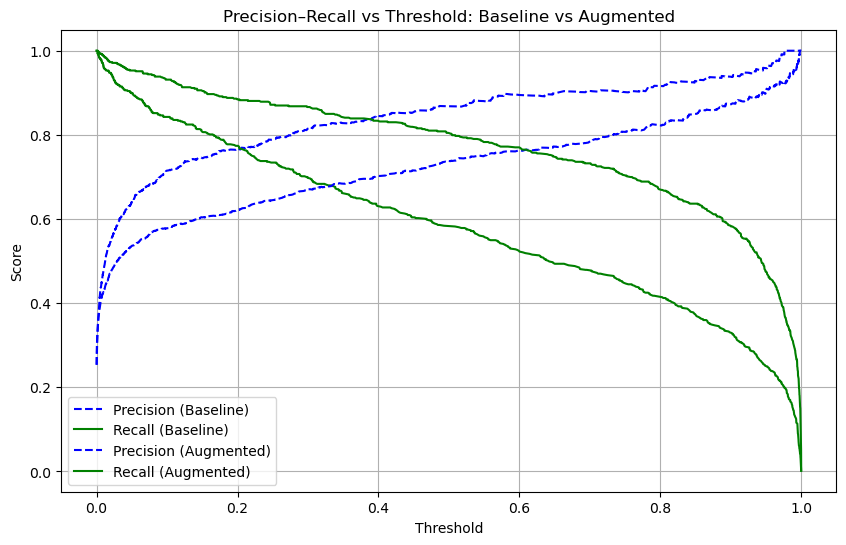

In [54]:
#visualizing the precision recall vs threshold for both models
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

prec_base, rec_base, thresh_base = precision_recall_curve(y_val, y_val_probs_base)
prec_aug, rec_aug, thresh_aug = precision_recall_curve(y_val, y_val_probs_aug)

def plot_pr_vs_thresh(precision, recall, thresholds, label):
    plt.plot(thresholds, precision[:-1], 'b--', label=f'Precision ({label})')
    plt.plot(thresholds, recall[:-1], 'g-', label=f'Recall ({label})')

plt.figure(figsize=(10,6))
plot_pr_vs_thresh(prec_base, rec_base, thresh_base, "Baseline")
plot_pr_vs_thresh(prec_aug, rec_aug, thresh_aug, "Augmented")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall vs Threshold: Baseline vs Augmented")
plt.grid(True)
plt.legend()
plt.show()


In [55]:
#Evaluation of both models
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

# Set manual thresholds 
threshold_baseline = 0.14 #0.08   # <-- Change manually
threshold_augmented = 0.35 #0.38 # <-- Change manually

# Predictions
# These should already be computed from model.predict
y_val_pred_proba_baseline = baseline_model.predict(X_val)
y_val_pred_proba_aug = aug_model.predict(X_val)

# Apply thresholds 
y_val_pred_baseline = (y_val_pred_proba_baseline >= threshold_baseline).astype(int)
y_val_pred_aug = (y_val_pred_proba_aug >= threshold_augmented).astype(int)

# Function to evaluate 
def evaluate_model(y_true, y_pred, model_name, threshold):
    print(f"\n=== {model_name} @ threshold={threshold:.2f} ===")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Evaluate both 
evaluate_model(y_val, y_val_pred_baseline, "Baseline Model", threshold_baseline)
evaluate_model(y_val, y_val_pred_aug, "Augmented Model", threshold_augmented)

# Auto-find threshold (optional) 
def find_best_threshold(y_true, y_proba, min_precision=0.7):
    thresholds = np.linspace(0, 1, 100)
    best_thresh = 0.5
    best_recall = 0
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        if p >= min_precision and r > best_recall:
            best_recall = r
            best_thresh = thresh
    return best_thresh, best_recall

best_t_baseline, best_r_baseline = find_best_threshold(y_val, y_val_pred_proba_baseline, min_precision=0.7)
best_t_augmented, best_r_augmented = find_best_threshold(y_val, y_val_pred_proba_aug, min_precision=0.7)

print(f"\nBest Threshold (Baseline) for recall≥max with precision≥0.7: {best_t_baseline:.2f}, Recall={best_r_baseline:.4f}")
print(f"Best Threshold (Augmented) for recall≥max with precision≥0.7: {best_t_augmented:.2f}, Recall={best_r_augmented:.4f}")


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

=== Baseline Model @ threshold=0.14 ===
              precision    recall  f1-score   support

           0     0.9363    0.9029    0.9193      1627
           1     0.7414    0.8192    0.7784       553

    accuracy                         0.8817      2180
   macro avg     0.8388    0.8610    0.8488      2180
weighted avg     0.8868    0.8817    0.8835      2180

Confusion Matrix:
 [[1469  158]
 [ 100  453]]

=== Augmented Model @ threshold=0.35 ===
              precision    recall  f1-score   support

           0     0.9413    0.8679    0.9031      1627
           1     0.6838    0.8409    0.7543       553

    accuracy                         0.8610      2180
   macro avg     0.8126    0.8544    0.8287      2180
weighted avg     0.8760    0.8610    0.8653      2180

Confusion Matrix:
 [[1412  215]
 [  88  465]]

Best Threshold (Baseline) for recall≥max with precision≥0.7: 0.09, Recall=0.8463
Best Thre

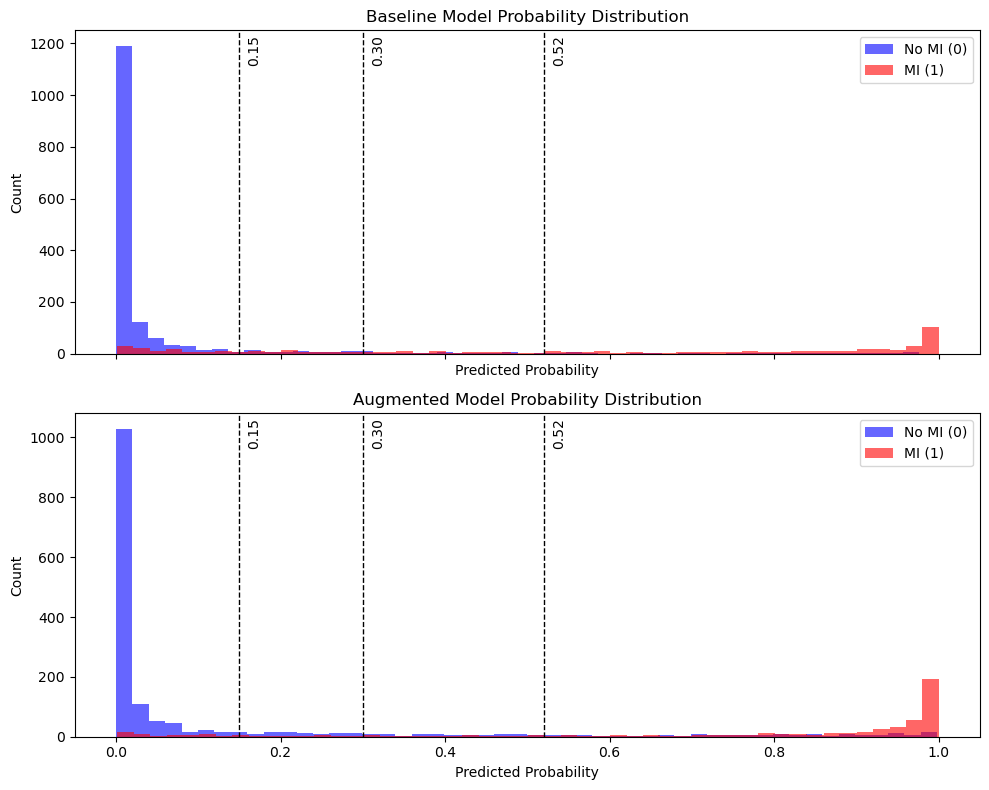

In [56]:
#visual of the performance
import matplotlib.pyplot as plt
import numpy as np

def plot_prob_distributions(y_true, y_pred_prob, thresholds, title):
    plt.hist(y_pred_prob[y_true == 0], bins=50, alpha=0.6, label="No MI (0)", color="blue")
    plt.hist(y_pred_prob[y_true == 1], bins=50, alpha=0.6, label="MI (1)", color="red")

    for thr in thresholds:
        plt.axvline(thr, color='k', linestyle='--', linewidth=1)
        plt.text(thr+0.01, plt.ylim()[1]*0.9, f"{thr:.2f}", rotation=90)

    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()

# Example plotting for both models
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Baseline
plt.sca(axes[0])
plot_prob_distributions(y_val, y_val_pred_proba_baseline, [0.15, 0.30, 0.52], "Baseline Model Probability Distribution")

# Augmented
plt.sca(axes[1])
plot_prob_distributions(y_val, y_val_pred_proba_aug, [0.15, 0.30, 0.52], "Augmented Model Probability Distribution")

plt.tight_layout()
plt.show()


In [57]:
#saving the best model 
import json
import os
import tensorflow as tf

# === 1. SAVE ===
SAVE_DIR = "Deep_Learning_mi_baseline"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save Keras model
model_path = os.path.join(SAVE_DIR, "Deep_learning_model.keras")
model.save(model_path)

# Save decision threshold and any preprocessing metadata you rely on
config = {
    "threshold": 0.08,                 # <- your chosen operating point
    "sampling_rate": 100,
    "target_length": 1000,
    "selected_leads": None,            # or a list like [0,1,2] if you used subsets
    "label_names": { "0": "No MI", "1": "MI" }
}
with open(os.path.join(SAVE_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=2)

print(f"Saved model to: {model_path}")
print(f"Saved config  to: {os.path.join(SAVE_DIR, 'config.json')}")


Saved model to: Deep_Learning_mi_baseline\Deep_learning_model.keras
Saved config  to: Deep_Learning_mi_baseline\config.json


In [58]:
#loading the model, 
SAVE_DIR = "Deep_Learning_mi_baseline"

loaded_model = tf.keras.models.load_model(os.path.join(SAVE_DIR, "Deep_learning_model.keras"))

with open(os.path.join(SAVE_DIR, "config.json")) as f:
    cfg = json.load(f)

THRESHOLD = float(cfg["threshold"])

def predict_with_threshold(ecg_batch):
    """
    ecg_batch: np.ndarray of shape (N, 1000, 12) preprocessed same way as training.
    Returns: dict with probabilities, hard labels using saved threshold.
    """
    probs = loaded_model.predict(ecg_batch, verbose=0).ravel()
    labels = (probs >= THRESHOLD).astype(int)
    return {"proba": probs, "label": labels}


VISUALIZATION OF THE DEE LEARNING MODEL

In [59]:
baseline_model.summary()
print([layer.name for layer in baseline_model.layers if isinstance(layer, tf.keras.layers.Conv1D)])
print(tf.__version__)
print(X_val.shape, y_val.shape)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 996, 32)        │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 996, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 498, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 498, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 494, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 494, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 247, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 247, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 243, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 243, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,789 (729.65 KB)

 Trainable params: 62,113 (242.63 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 124,228 (485.27 KB)

['conv1d_12', 'conv1d_13', 'conv1d_14']
2.20.0
(2180, 1000, 12) (2180,)


In [60]:
print([layer.name for layer in aug_model.layers if isinstance(layer, tf.keras.layers.Conv1D)])
print([layer.name for layer in baseline_model.layers if isinstance(layer, tf.keras.layers.Conv1D)])

['conv1d_15', 'conv1d_16', 'conv1d_17']
['conv1d_12', 'conv1d_13', 'conv1d_14']


In [61]:
print(X_val.shape, y_val.shape)

(2180, 1000, 12) (2180,)


In [62]:
aug_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 996, 32)        │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 996, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 498, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 498, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 494, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 494, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 247, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 247, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 243, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 243, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,789 (729.65 KB)

 Trainable params: 62,113 (242.63 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 124,228 (485.27 KB)

Baseline model built successfully. Output shape: (None, 1)
Baseline Conv1D layers: ['conv1d_12', 'conv1d_13', 'conv1d_14']
Augmented model built successfully. Output shape: (None, 1)
Augmented Conv1D layers: ['conv1d_15', 'conv1d_16', 'conv1d_17']
Model output shape in compute_gradcam: (1, 1)


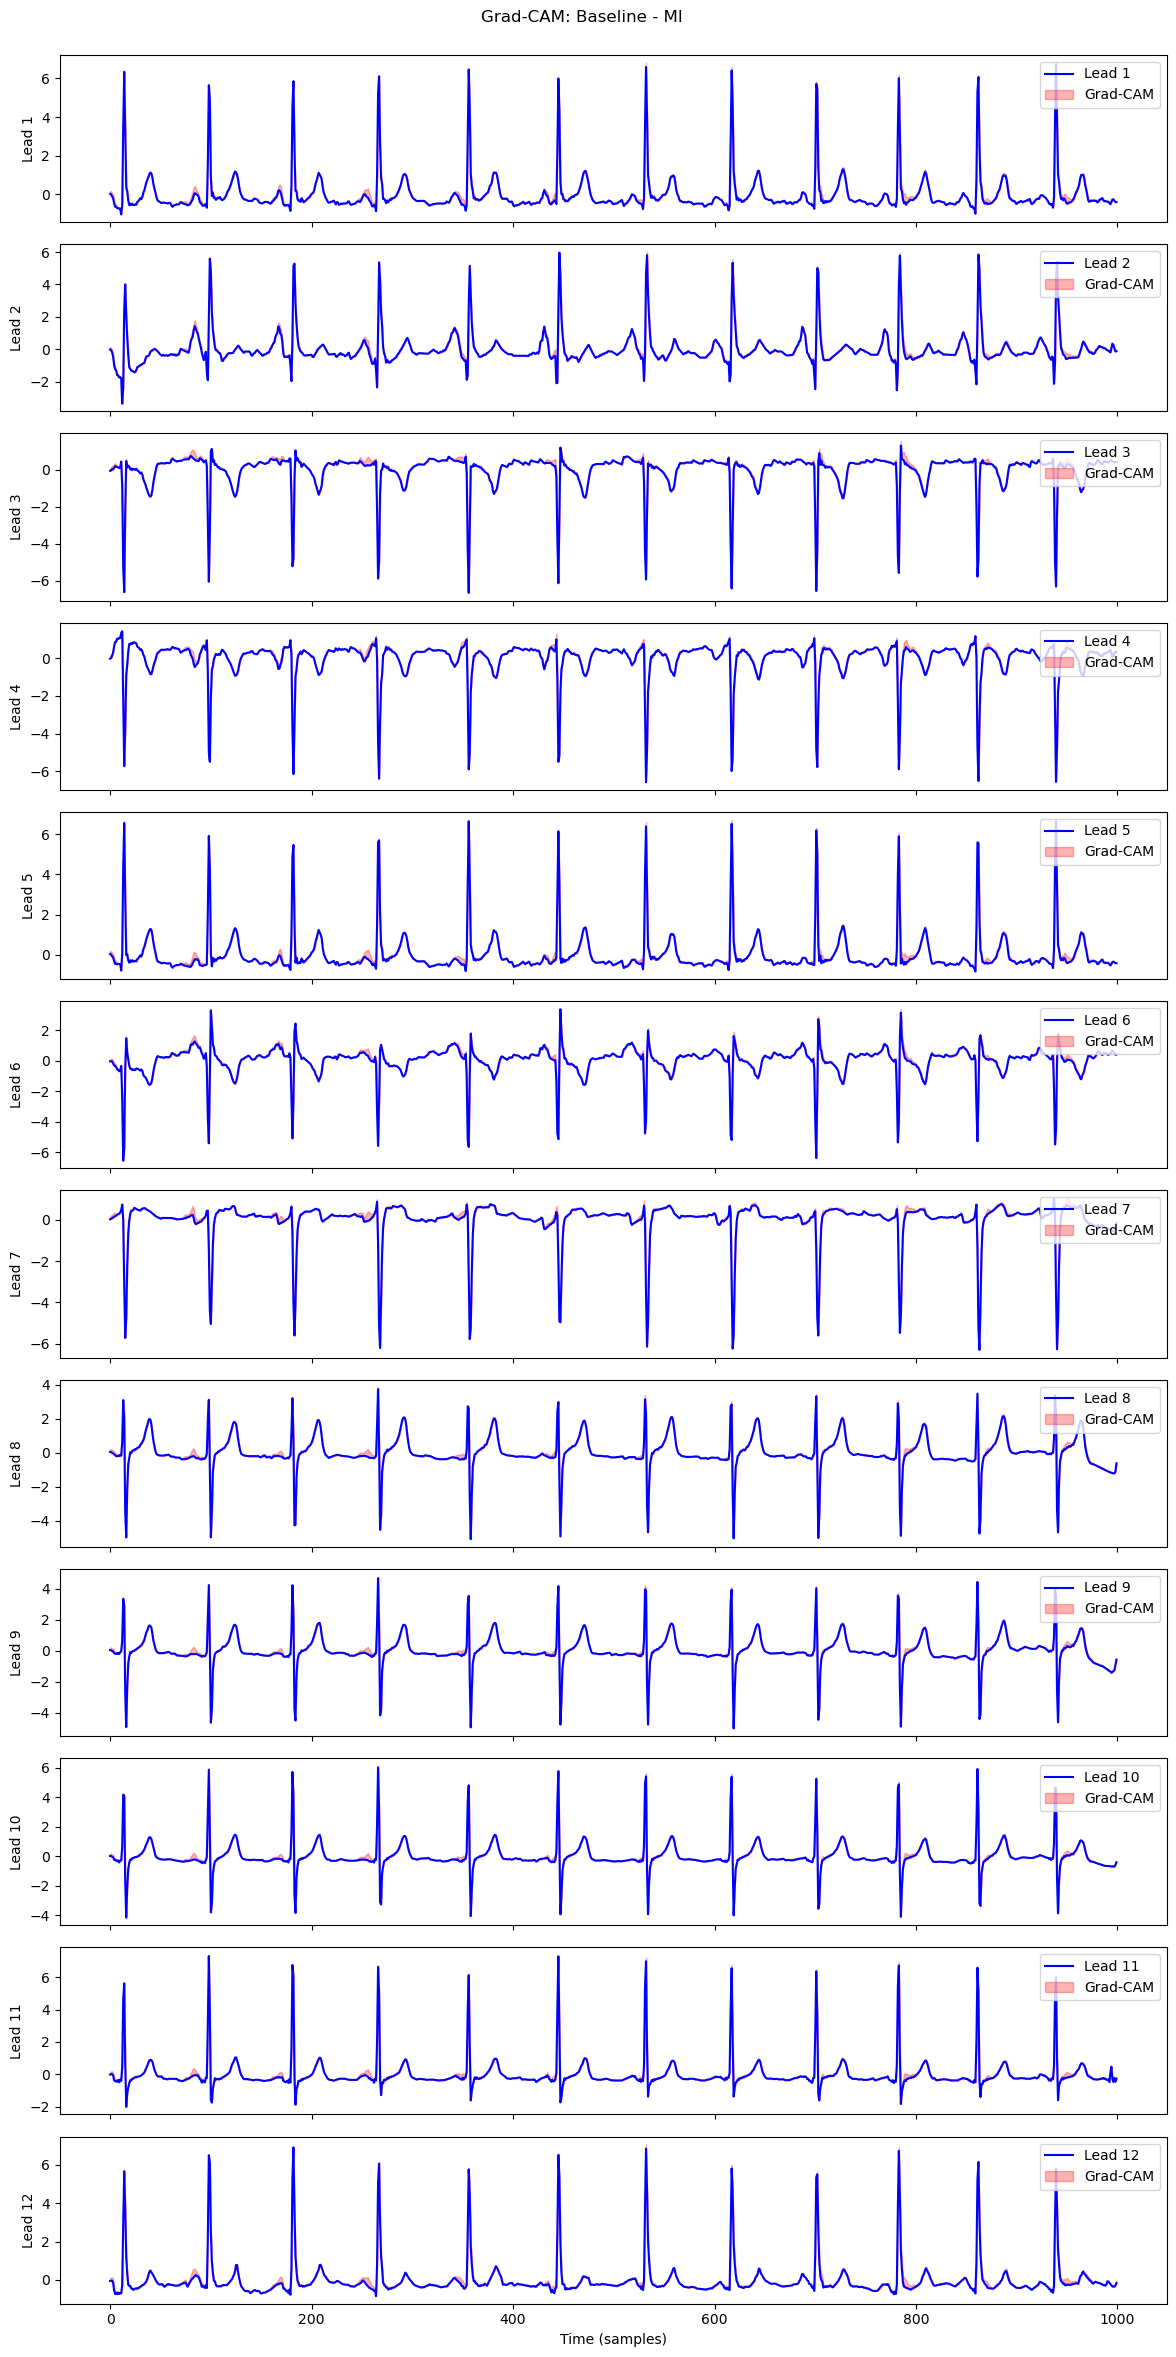

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_405
Received: inputs=['Tensor(shape=(50, 1000, 12))']
  warnings.warn(msg)
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_405
Received: inputs=['Tensor(shape=(100, 1000, 12))']
  warnings.warn(msg)


SHAP failed for Baseline (pos): SHAP computation failed: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: tensorflow - Max. diff: nan - Tolerance: 0.01. Ensure model and input data are compatible.
Model output shape in compute_gradcam: (1, 1)


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_405
Received: inputs=['Tensor(shape=(1, 1000, 12))']
  warnings.warn(msg)


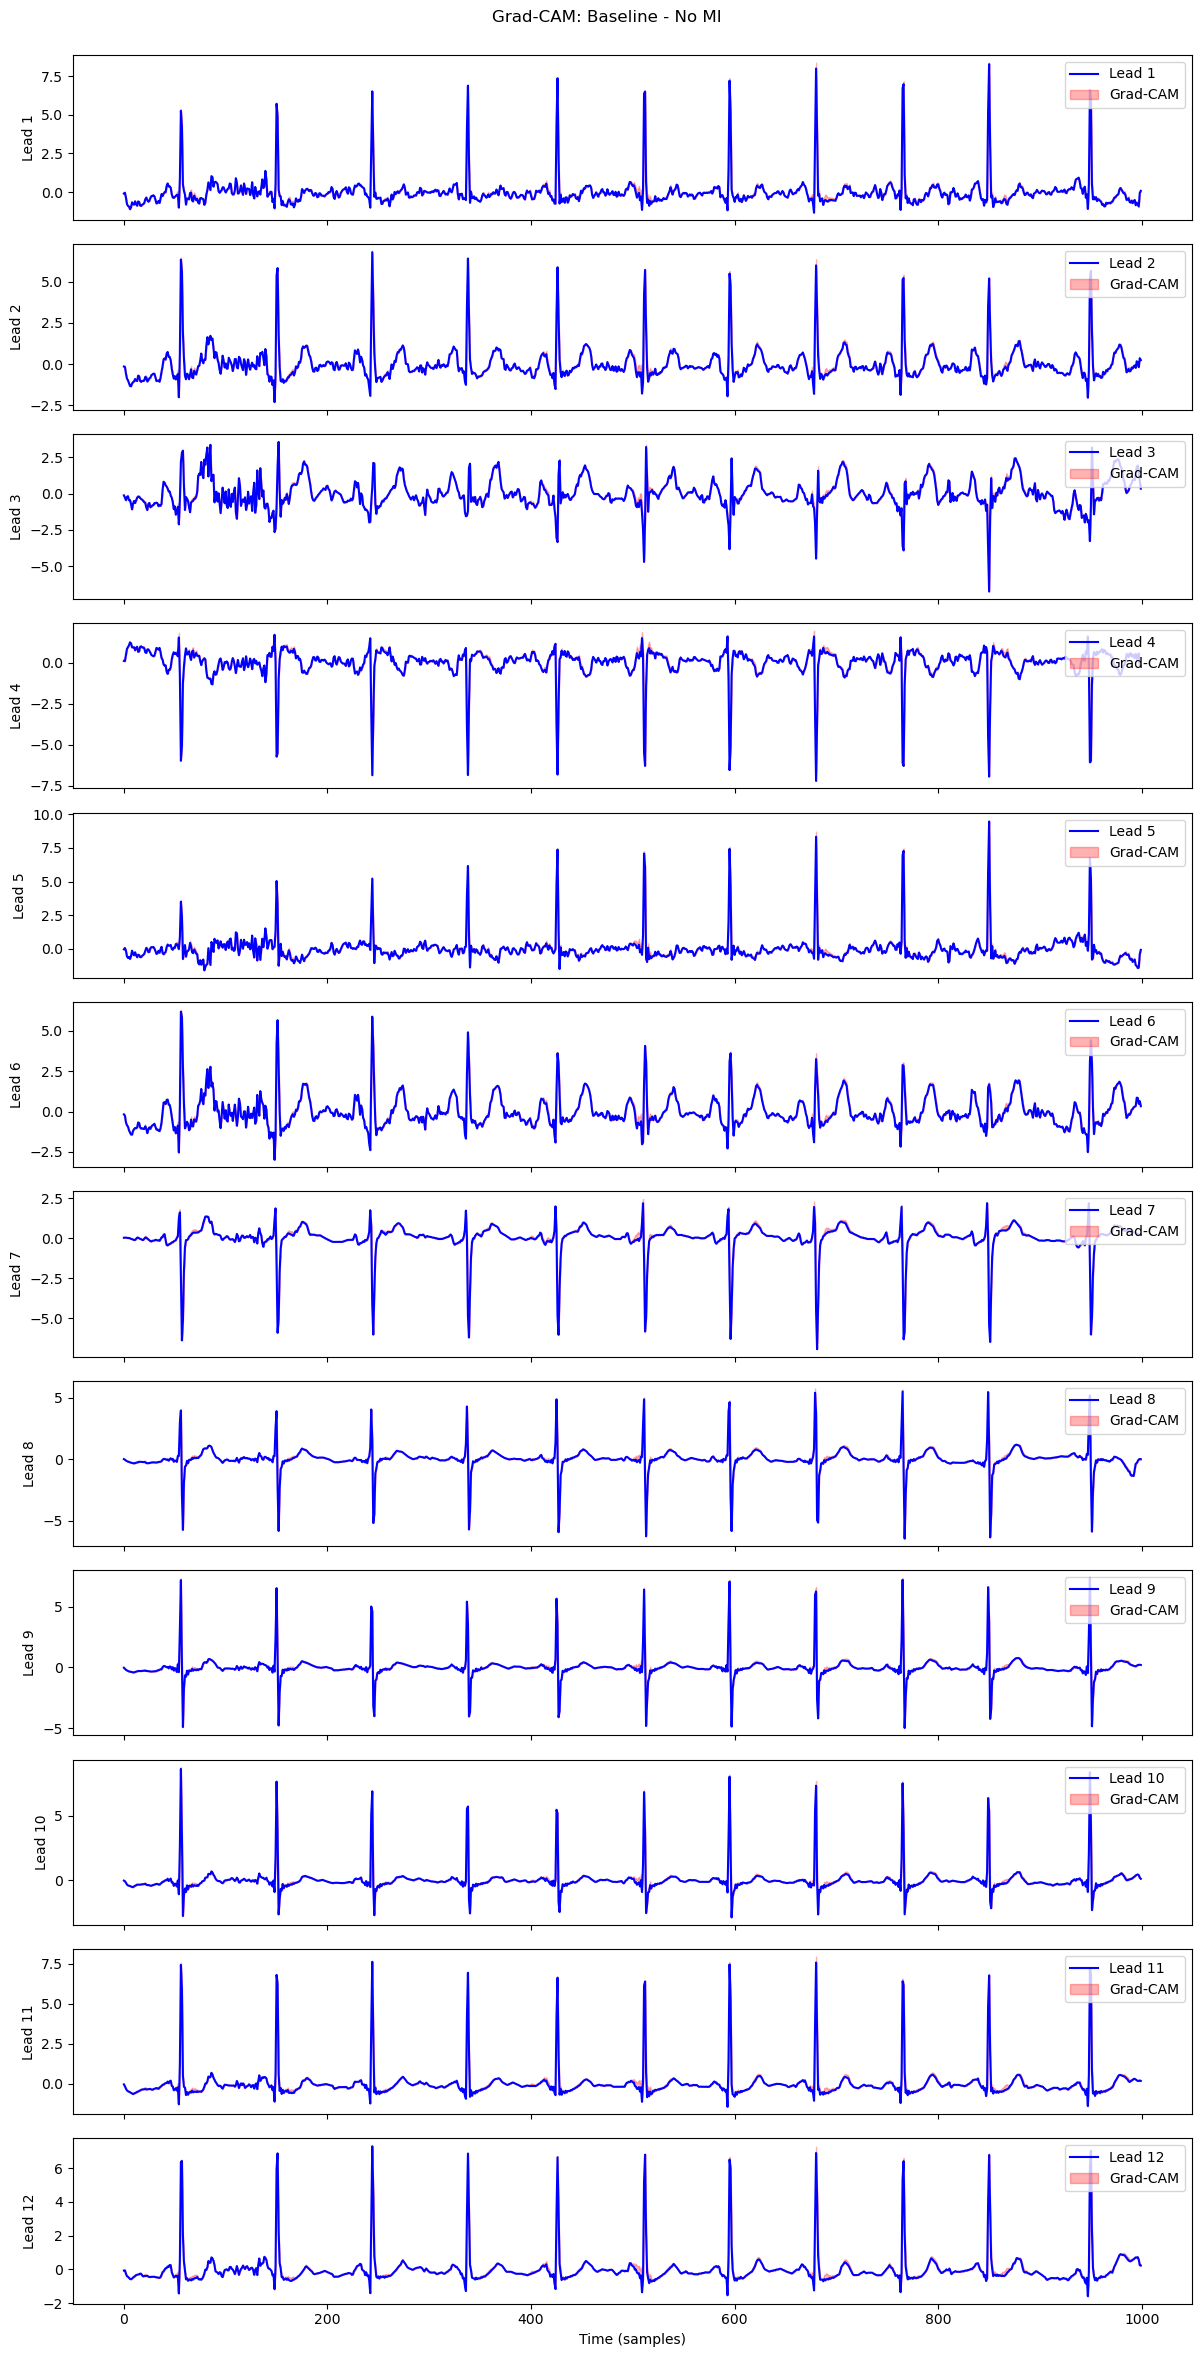

SHAP failed for Baseline (neg): SHAP computation failed: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: tensorflow - Max. diff: nan - Tolerance: 0.01. Ensure model and input data are compatible.
Model output shape in compute_gradcam: (1, 1)


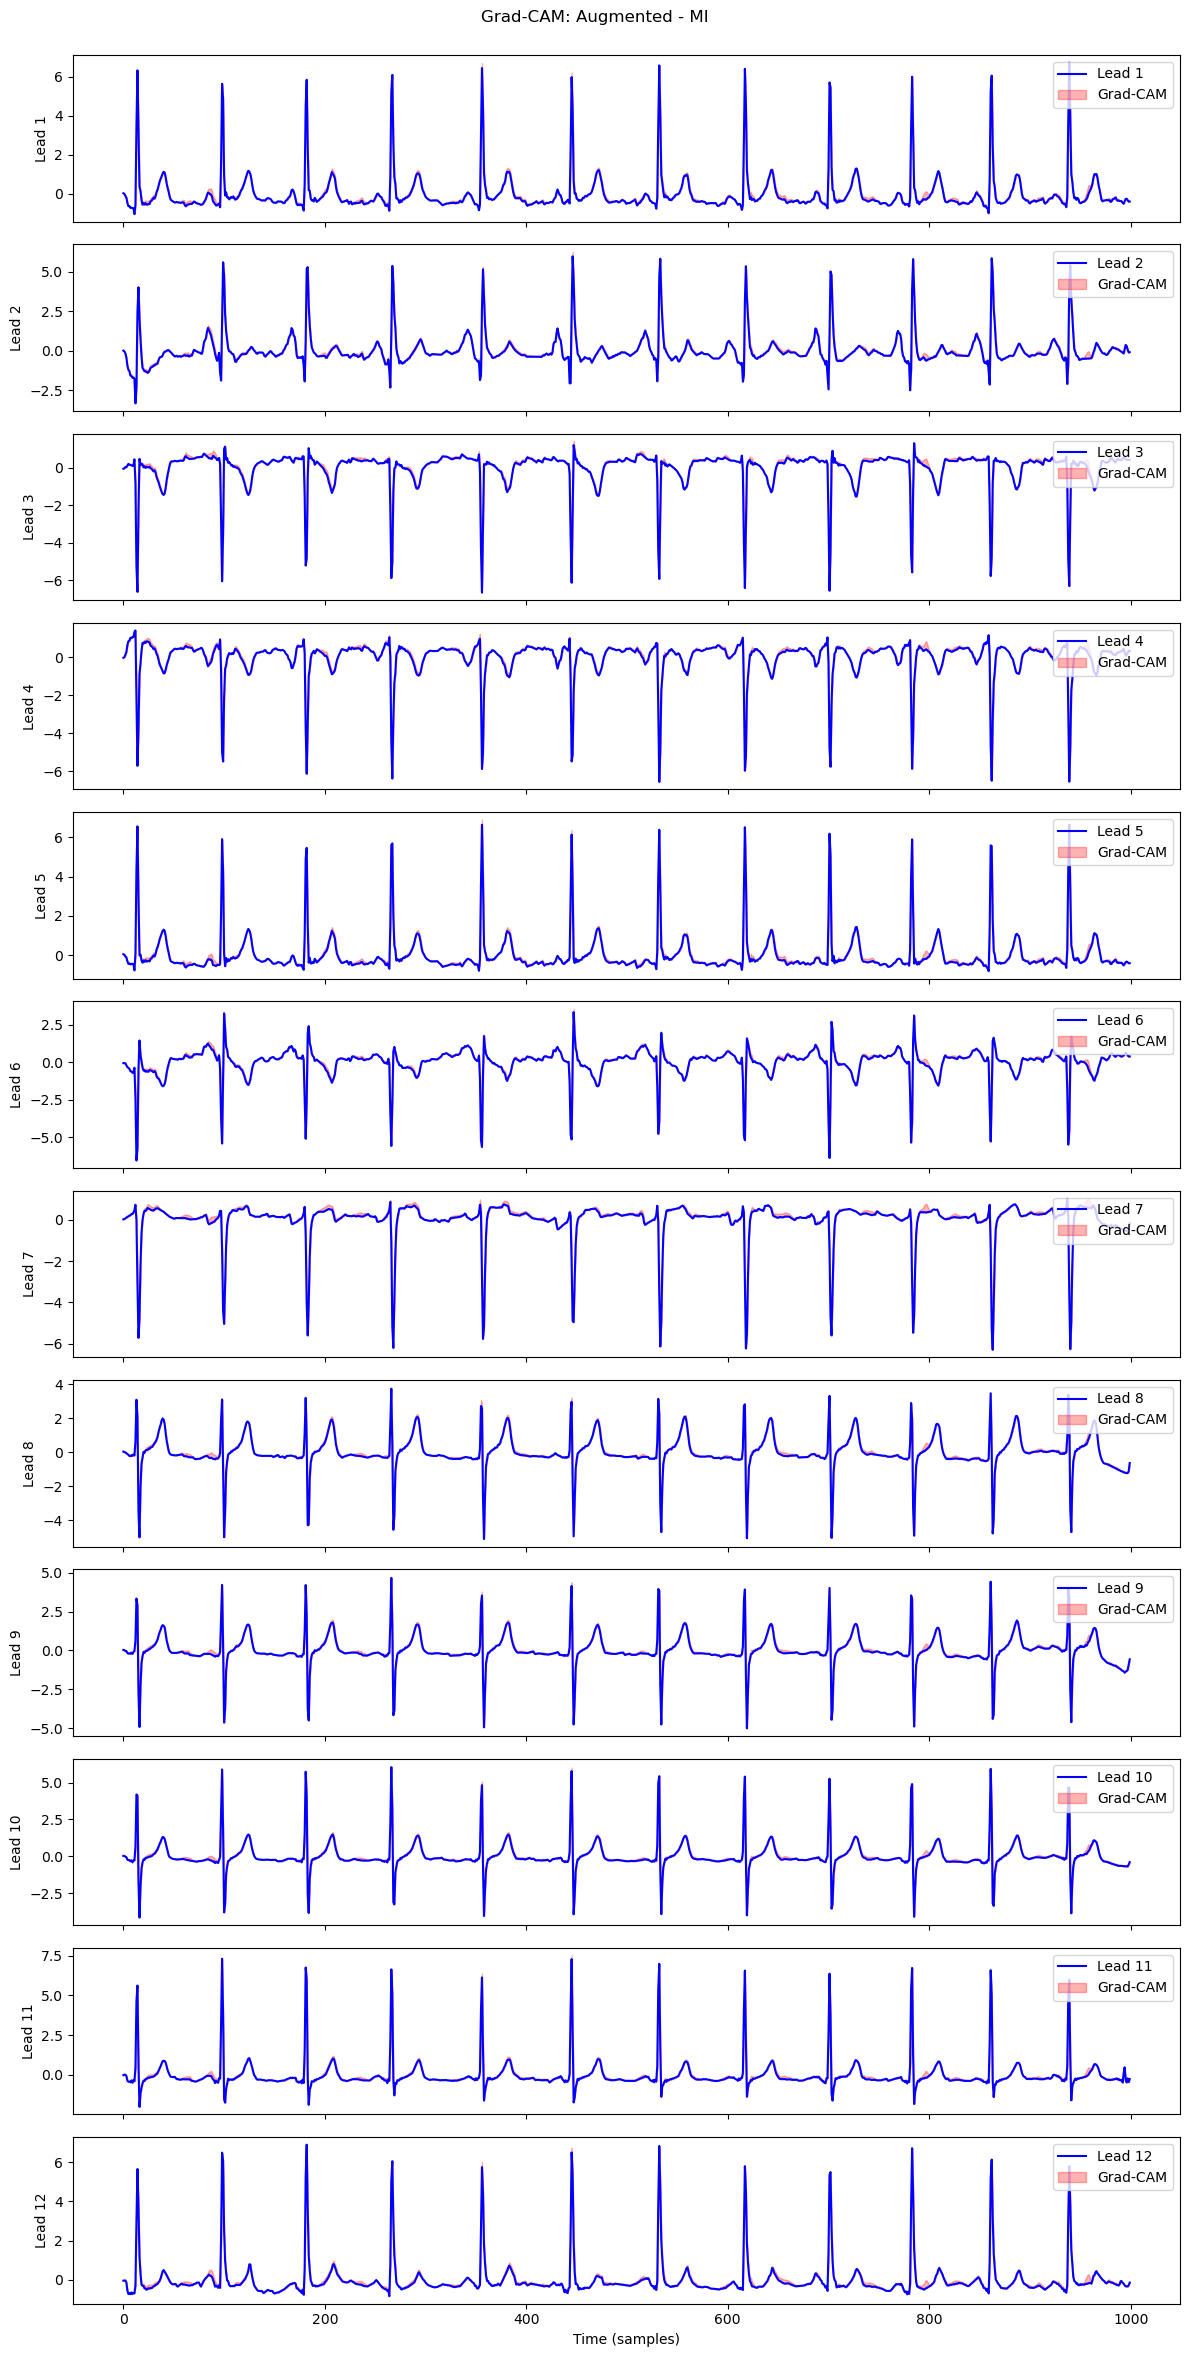

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_420
Received: inputs=['Tensor(shape=(50, 1000, 12))']
  warnings.warn(msg)
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_420
Received: inputs=['Tensor(shape=(100, 1000, 12))']
  warnings.warn(msg)
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_420
Received: inputs=['Tensor(shape=(1, 1000, 12))']
  warnings.warn(msg)


SHAP failed for Augmented (pos): SHAP computation failed: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: tensorflow - Max. diff: nan - Tolerance: 0.01. Ensure model and input data are compatible.
Model output shape in compute_gradcam: (1, 1)


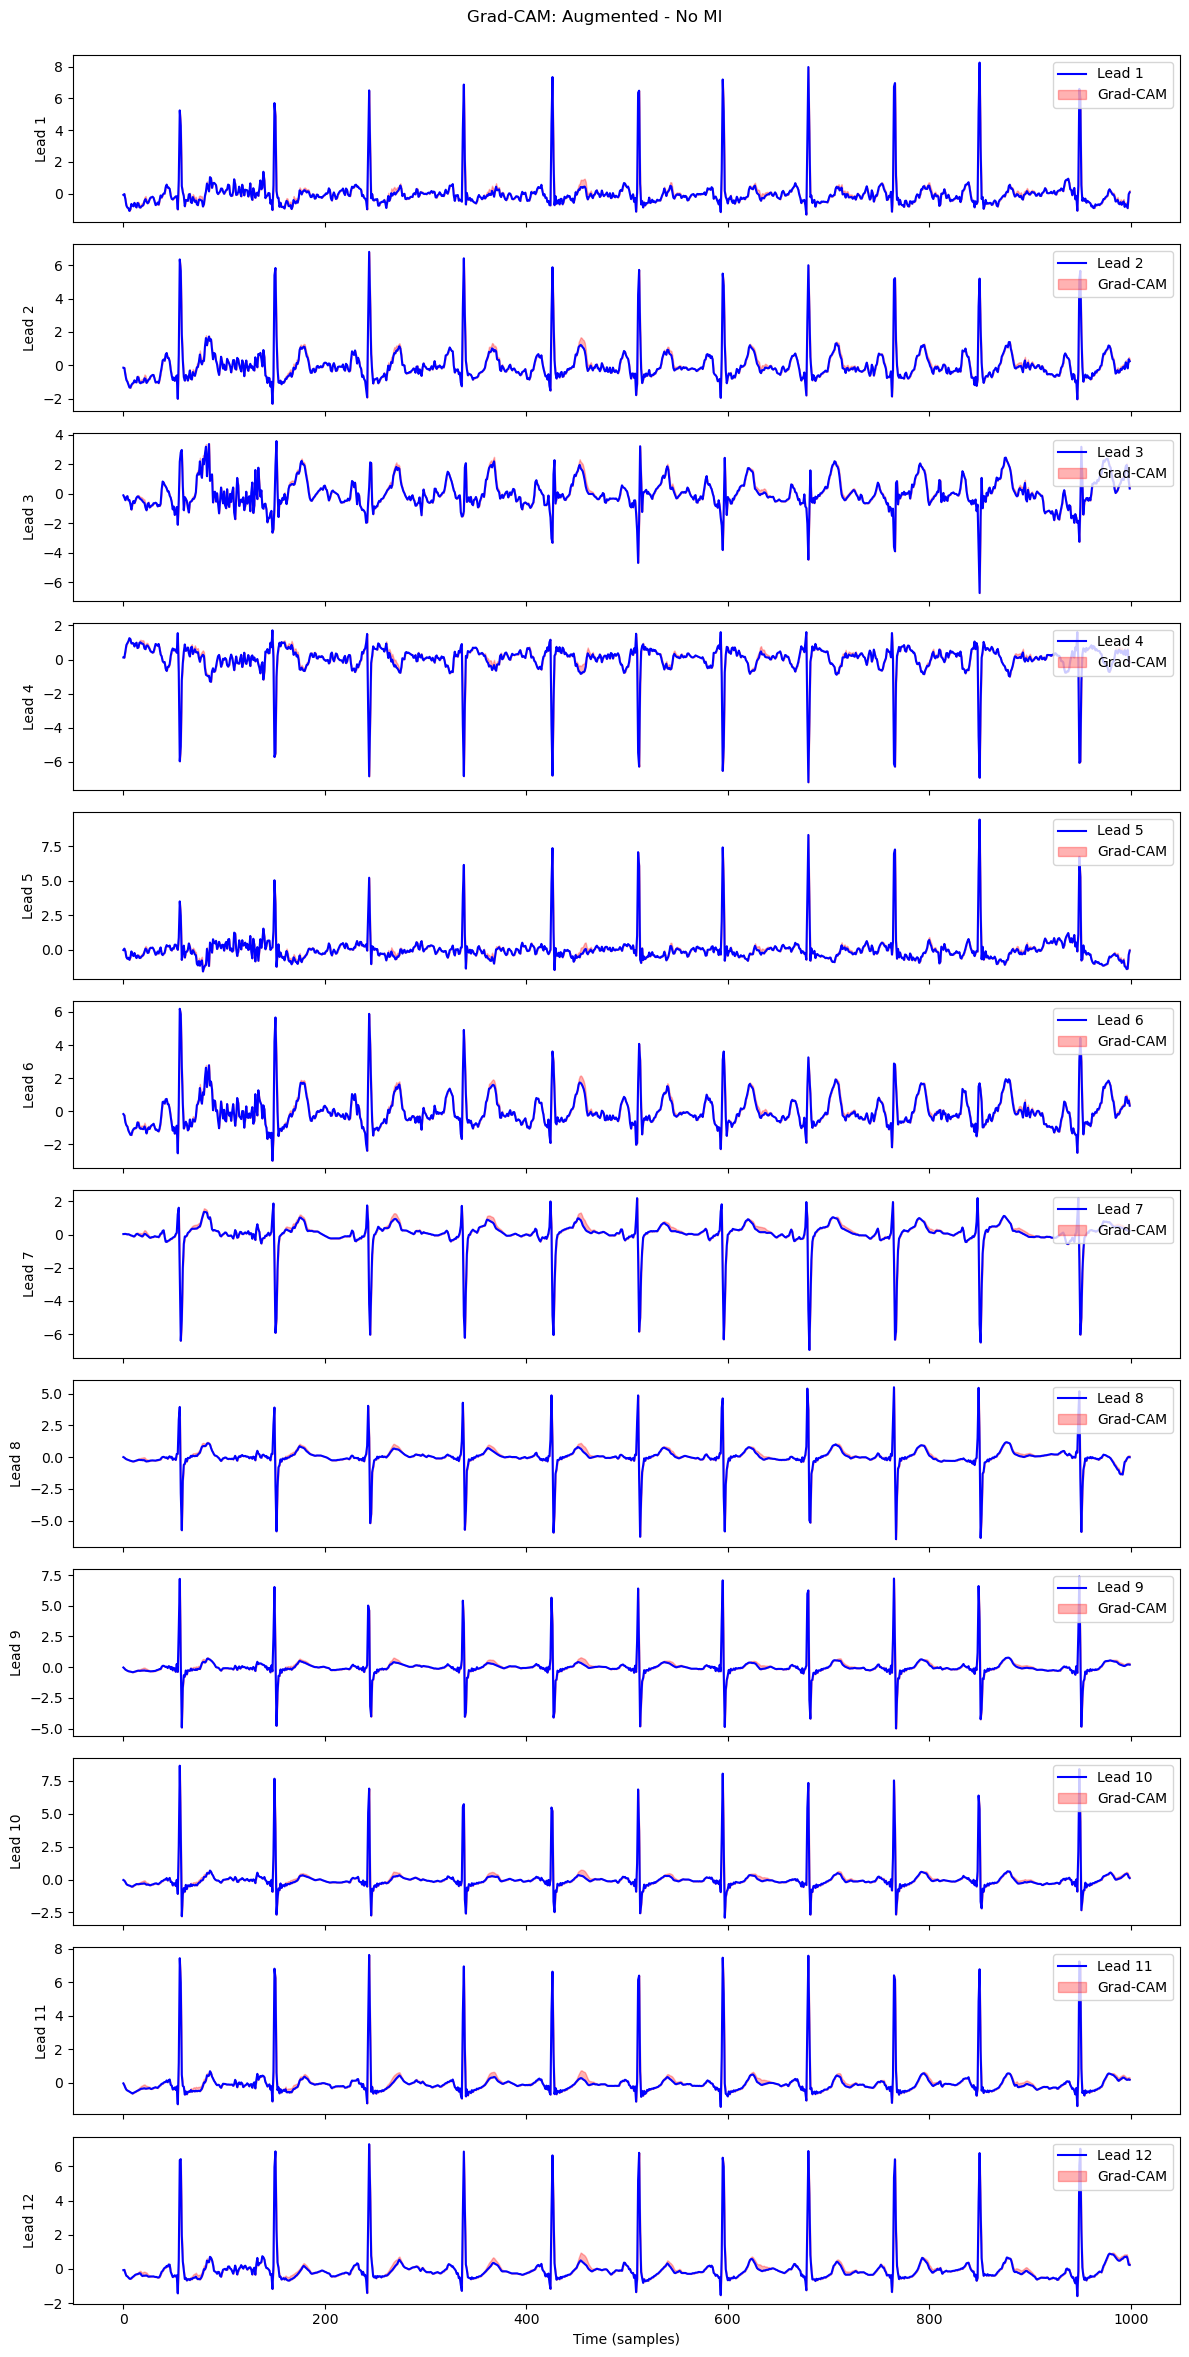

SHAP failed for Augmented (neg): SHAP computation failed: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: tensorflow - Max. diff: nan - Tolerance: 0.01. Ensure model and input data are compatible.


In [63]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
from scipy.interpolate import interp1d

# Ensure output directory exists
os.makedirs('ecg_explanations', exist_ok=True)

# Helper function to find the last Conv1D layer
def get_last_conv1d_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv1D):
            return layer.name
    raise ValueError("No Conv1D layer found in the model.")

# Grad-CAM implementation for 1D CNN (direct gradient computation)
def compute_gradcam(model, input_data, layer_name, class_idx=0):
    input_data = tf.convert_to_tensor(input_data)
    
    # Ensure model is called to define output
    try:
        model_output = model(input_data)
        print(f"Model output shape in compute_gradcam: {model_output.shape}")
    except Exception as e:
        raise ValueError(f"Model call failed: {str(e)}. Ensure model is built and input shape is (batch_size, 1000, 12).")
    
    # Get the Conv1D layer
    try:
        conv_layer = model.get_layer(layer_name)
    except Exception as e:
        raise ValueError(f"Failed to get layer {layer_name}: {str(e)}. Check layer name.")
    
    # Compute Conv1D output and gradients in a single tape
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_data)
        # Manually apply layers up to the Conv1D layer
        x = input_data
        for layer in model.layers:
            x = layer(x)
            if layer.name == layer_name:
                conv_out = x
        model_out = x  # Final output after all layers
        
        # Handle single-output (sigmoid) or multi-output (softmax)
        if model_out.shape[-1] == 1:
            target_output = model_out[:, 0]  # Sigmoid
        else:
            target_output = model_out[:, class_idx]  # Softmax
    
    # Compute gradients
    conv_grads = tape.gradient(target_output, conv_out)
    del tape
    
    # Pool gradients and compute heatmap
    pooled_grads = tf.reduce_mean(conv_grads, axis=(0, 1))
    conv_out = conv_out[0]
    heatmap = tf.reduce_mean(conv_out * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-10)
    
    # Upsample heatmap to match input timesteps (1000)
    x = np.linspace(0, 1, len(heatmap))
    x_new = np.linspace(0, 1, input_data.shape[1])
    f = interp1d(x, heatmap, kind='linear')
    heatmap_upsampled = f(x_new)
    return heatmap_upsampled

# Plot Grad-CAM heatmap for all leads
def plot_gradcam(ecg, heatmap, label, model_name, save_path):
    fig, axes = plt.subplots(12, 1, figsize=(12, 24), sharex=True)
    timesteps = np.arange(ecg.shape[0])
    for lead in range(12):
        axes[lead].plot(timesteps, ecg[:, lead], label=f'Lead {lead+1}', color='blue')
        axes[lead].fill_between(timesteps, ecg[:, lead], ecg[:, lead] + heatmap * 0.5, 
                               alpha=0.3, color='red', label='Grad-CAM')
        axes[lead].set_ylabel(f'Lead {lead+1}')
        axes[lead].legend(loc='upper right')
    axes[-1].set_xlabel('Time (samples)')
    plt.suptitle(f'Grad-CAM: {model_name} - {"MI" if label == 1 else "No MI"}')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(save_path)
    plt.show()
    plt.close()

# SHAP explanation for all leads (handles sigmoid or softmax)
def compute_shap(model, input_data, background_data):
    try:
        explainer = shap.DeepExplainer(model, background_data)
        shap_values = explainer.shap_values(input_data)

        if isinstance(shap_values, list) and len(shap_values) == 1:
            return shap_values[0]  # Sigmoid: single output
        elif len(shap_values) > 1:
            return shap_values[1]  # Softmax: take class 1 (MI)
    except Exception as e:
        raise ValueError(f"SHAP computation failed: {str(e)}. Ensure model and input data are compatible.")

# Plot SHAP heatmap for all leads
def plot_shap(ecg, shap_values, label, model_name, save_path):
    fig, axes = plt.subplots(12, 1, figsize=(12, 24), sharex=True)
    timesteps = np.arange(ecg.shape[0])
    for lead in range(12):
        axes[lead].plot(timesteps, ecg[:, lead], label=f'Lead {lead+1}', color='blue')
        axes[lead].fill_between(timesteps, ecg[:, lead], 
                               ecg[:, lead] + shap_values[:, lead] * 0.5, 
                               alpha=0.3, color='purple', label='SHAP')
        axes[lead].set_ylabel(f'Lead {lead+1}')
        axes[lead].legend(loc='upper right')
    axes[-1].set_xlabel('Time (samples)')
    plt.suptitle(f'SHAP: {model_name} - {"MI" if label == 1 else "No MI"}')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(save_path)
    plt.show()
    plt.close()

# Main function to generate explanations
def generate_explanations(baseline_model, aug_model, X_val_np, y_val, save_dir='ecg_explanations'):
    # Verify input data shapes
    if X_val_np.shape[1:] != (1000, 12):
        raise ValueError(f"Expected X_val_np shape (n_samples, 1000, 12), got {X_val_np.shape}")
    if y_val.shape[0] != X_val_np.shape[0]:
        raise ValueError(f"y_val length {y_val.shape[0]} does not match X_val_np samples {X_val_np.shape[0]}")

    # Select one positive (MI) and one negative (No MI) example
    pos_idx = np.where(y_val == 1)[0][0]  # First positive example
    neg_idx = np.where(y_val == 0)[0][0]  # First negative example
    samples = [(X_val_np[pos_idx:pos_idx+1], y_val[pos_idx], 'pos'), 
               (X_val_np[neg_idx:neg_idx+1], y_val[neg_idx], 'neg')]
    
    # Background data for SHAP
    background = X_val_np[np.random.choice(X_val_np.shape[0], 50, replace=False)]
    
    # Ensure models are built
    for model, model_name in [(baseline_model, 'Baseline'), (aug_model, 'Augmented')]:
        try:
            model.build((None, 1000, 12))  # Explicitly build with input shape
            # Call with a real input sample to ensure graph is built
            model(X_val_np[:1])  # Use first sample from X_val_np
            print(f"{model_name} model built successfully. Output shape: {model.output_shape}")
            # Print Conv1D layers for debugging
            conv_layers = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv1D)]
            print(f"{model_name} Conv1D layers: {conv_layers}")
        except Exception as e:
            raise ValueError(f"Failed to build {model_name} model: {str(e)}. Check build_cnn function.")
    
    # Get last Conv1D layer names
    last_conv_base = get_last_conv1d_name(baseline_model)
    last_conv_aug = get_last_conv1d_name(aug_model)
    
    for model, model_name, last_conv in [(baseline_model, 'Baseline', last_conv_base), 
                                        (aug_model, 'Augmented', last_conv_aug)]:
        for sample, label, sample_type in samples:
            # Grad-CAM
            try:
                heatmap = compute_gradcam(model, sample, last_conv, class_idx=0)  # Use 0 for sigmoid
                plot_gradcam(sample[0], heatmap, label, model_name, 
                            f'{save_dir}/{model_name}_GradCAM_{sample_type}.png')
            except Exception as e:
                print(f"Grad-CAM failed for {model_name} ({sample_type}): {str(e)}")
                continue
            
            # SHAP
            try:
                shap_values = compute_shap(model, sample, background)
                plot_shap(sample[0], shap_values[0], label, model_name, 
                         f'{save_dir}/{model_name}_SHAP_{sample_type}.png')
            except Exception as e:
                print(f"SHAP failed for {model_name} ({sample_type}): {str(e)}")
                continue

# Run explanations
try:
    generate_explanations(baseline_model, aug_model, X_val, y_val)
except Exception as e:
    print(f"Error in generate_explanations: {str(e)}")

In [64]:
print(X_val.shape, y_val.shape)
print(np.any(np.isnan(X_val)))  # Check for NaNs

(2180, 1000, 12) (2180,)
True


In [65]:
from tensorflow.keras.models import load_model

model = load_model(r"C:\Users\user\Desktop\MYOCARDIAL DETECTION PROJECT\WORKSPACE\ML ALGORITHMS\best_cnn_model.keras")
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 996, 32)        │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 996, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 498, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 498, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 494, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 494, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 247, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 247, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 243, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 243, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,789 (729.65 KB)

 Trainable params: 62,113 (242.63 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 124,228 (485.27 KB)

APPLYING A HYBRID LATE FUSION INFERENCE PIPELINE

In [66]:
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# ==== 1️⃣ Define the FixedWeightedEnsemble class ====
class FixedWeightedEnsemble:
    def __init__(self, svm_weight=0.7, rf_weight=0.3, threshold=0.35):
        self.svm_weight = svm_weight
        self.rf_weight = rf_weight
        self.threshold = threshold
        self.svm_model = None
        self.rf_model = None
        self.svm_features = None
        self.rf_features = None

    def set_models(self, svm_model, rf_model):
        self.svm_model = svm_model
        self.rf_model = rf_model

    def set_feature_lists(self, svm_features, rf_features):
        self.svm_features = svm_features
        self.rf_features = rf_features

    def predict_proba(self, X_svm, X_rf):
        svm_prob = self.svm_model.predict_proba(X_svm)[:, 1]
        rf_prob = self.rf_model.predict_proba(X_rf)[:, 1]
        return self.svm_weight * svm_prob + self.rf_weight * rf_prob

    def predict(self, X_svm, X_rf):
        probs = self.predict_proba(X_svm, X_rf)
        return (probs >= self.threshold).astype(int)

# ==== 2️⃣ Load both models ====
dl_model_path = r"C:\Users\user\Desktop\MYOCARDIAL DETECTION PROJECT\WORKSPACE\ML ALGORITHMS\best_cnn_model.keras"
ml_model_path = r"C:\Users\user\Desktop\MYOCARDIAL DETECTION PROJECT\WORKSPACE\ML ALGORITHMS\final_weighted_ensemble_model.joblib"

# If you need to use the interaction features function, make sure it's defined in the notebook:
import pandas as pd
def create_interaction_features(X):
    interactions = pd.DataFrame({
        'age_sysBP': X['age'] * X['sysBP'],
        'glucose_BMI': X['glucose'] * X['BMI'],
        'cigsPerDay_totChol': X['cigsPerDay'] * X['totChol'],
        'BMI_heartRate': X['BMI'] * X['heartRate'],
        'diaBP_sysBP': X['diaBP'] * X['sysBP'],
    }, index=X.index)
    return pd.concat([X, interactions], axis=1)

# Load the deep learning (CNN) model
dl_model = load_model(dl_model_path)

# Load the ensemble model bundle
ensemble_bundle = joblib.load(ml_model_path)

ml_model = ensemble_bundle['model']
svm_model = ensemble_bundle['svm_model']
rf_model = ensemble_bundle['rf_model']
svm_features = ensemble_bundle['svm_features']
rf_features = ensemble_bundle['rf_features']

# ==== 3️⃣ Create DL feature extractor (128-D) ====
feature_extractor = tf.keras.Model(
    inputs=dl_model.layers[0].input,
    outputs=dl_model.get_layer("global_average_pooling1d").output
)

# ==== 4️⃣ Function for hybrid prediction ====
def hybrid_predict(ecg_batch, structured_features):
    """
    ecg_batch: np.array of shape (n_samples, 1000, 12)
    structured_features: pd.DataFrame of shape (n_samples, n_structured_features)
    """
    # 1. Get 128-D features from CNN
    ecg_embeddings = feature_extractor.predict(ecg_batch)

    # 2. Scale structured features
    scaler = StandardScaler()
    structured_scaled = scaler.fit_transform(structured_features)

    # 3. Concatenate DL and structured features
    fused_features = np.hstack([ecg_embeddings, structured_scaled])

    # 4. Select features for SVM and RF based on saved feature lists
    # If the required features are not present, use all structured features
    svm_cols = [f for f in svm_features if f in structured_features.columns]
    rf_cols = [f for f in rf_features if f in structured_features.columns]

    if svm_cols:
        X_svm_structured = structured_features[svm_cols].values
        X_svm_structured_scaled = scaler.fit_transform(X_svm_structured)
        X_svm = np.hstack([ecg_embeddings, X_svm_structured_scaled])
    else:
        X_svm = fused_features

    if rf_cols:
        X_rf_structured = structured_features[rf_cols].values
        X_rf_structured_scaled = scaler.fit_transform(X_rf_structured)
        X_rf = np.hstack([ecg_embeddings, X_rf_structured_scaled])
    else:
        X_rf = fused_features

    # 5. Predict with structured ML model
    predictions = ml_model.predict_proba(X_svm, X_rf)
    return predictions

# Example usage usin dummy data
# Example dummy data (replace with real data)
ecg_sample = np.random.rand(1, 1000, 12)  # Shape: (n_samples, 1000, 12)
structured_sample = np.random.rand(1, 10)  # Shape: (n_samples, n_structured_features)

# If structured_sample is a DataFrame, ensure it has column names
# For dummy data, create dummy column names
import pandas as pd
structured_sample = pd.DataFrame(structured_sample, columns=[f'feature_{i}' for i in range(10)])

# Make predictions
pred_prob = hybrid_predict(ecg_sample, structured_sample)
# If pred_prob is an array, print the first element; if it's a scalar, print directly
if isinstance(pred_prob, (np.ndarray, list)):
    # Flatten and get the first scalar value
    print(f"Probability of MI: {np.ravel(pred_prob)[0]:.4f}")
else:
    print(f"Probability of MI: {pred_prob:.4f}")

ValueError: No such layer: global_average_pooling1d. Existing layers are: ['conv1d_9', 'batch_normalization_9', 'max_pooling1d_6', 'dropout_9', 'conv1d_10', 'batch_normalization_10', 'max_pooling1d_7', 'dropout_10', 'conv1d_11', 'batch_normalization_11', 'global_average_pooling1d_3', 'dense_6', 'dropout_11', 'dense_7'].

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import pandas as pd

# Define create_interaction_features if needed for joblib loading
def create_interaction_features(df):
    # Example implementation, replace with your actual function
    # This should match the function used when saving the joblib file
    # For example:
    # df['age_sex'] = df['age'] * df['sex']
    # return df
    return df

# ===== 1. Load CNN Model =====
dl_model_path = r"C:\Users\user\Desktop\MYOCARDIAL DETECTION PROJECT\WORKSPACE\ML ALGORITHMS\best_cnn_model.keras"
dl_model = load_model(dl_model_path)

# ===== 2. Load Structured Model (FixedWeightedEnsemble) =====
class FixedWeightedEnsemble:
    def __init__(self, svm_weight=0.7, rf_weight=0.3, threshold=0.35):
        self.svm_weight = svm_weight
        self.rf_weight = rf_weight
        self.threshold = threshold
        self.svm_model = None
        self.rf_model = None
        self.svm_features = None
        self.rf_features = None

    def set_models(self, svm_model, rf_model):
        self.svm_model = svm_model
        self.rf_model = rf_model

    def set_feature_lists(self, svm_features, rf_features):
        self.svm_features = svm_features
        self.rf_features = rf_features

    def predict_proba(self, X):
        svm_probs = self.svm_model.predict_proba(X[self.svm_features])[:, 1]
        rf_probs = self.rf_model.predict_proba(X[self.rf_features])[:, 1]
        weighted_probs = (
            self.svm_weight * svm_probs +
            self.rf_weight * rf_probs
        ) / (self.svm_weight + self.rf_weight)
        return weighted_probs

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs >= self.threshold).astype(int)

ml_model_path = r"C:\Users\user\Desktop\MYOCARDIAL DETECTION PROJECT\WORKSPACE\ML ALGORITHMS\final_weighted_ensemble_model.joblib"
bundle = joblib.load(ml_model_path)

ml_model = bundle['model']
ml_model.set_models(bundle['svm_model'], bundle['rf_model'])
ml_model.set_feature_lists(bundle['svm_features'], bundle['rf_features'])

# ===== 3. Late Fusion Inference Function =====
def late_fusion_predict(ecg_batch, structured_df, cnn_weight=0.6, ml_weight=0.4, threshold=0.5):
    """
    ecg_batch: np.array of shape (batch, 1000, 12)
    structured_df: pandas DataFrame with feature columns
    cnn_weight, ml_weight: weights for late fusion
    threshold: probability cutoff for classification
    """
    # CNN probabilities
    cnn_probs = dl_model.predict(ecg_batch).reshape(-1)

    # Structured probabilities
    ml_probs = ml_model.predict_proba(structured_df).reshape(-1)

    # Weighted average fusion
    final_probs = (cnn_weight * cnn_probs + ml_weight * ml_probs) / (cnn_weight + ml_weight)

    # Final binary prediction
    final_preds = (final_probs >= threshold).astype(int)

    return final_probs, final_preds

# ===== 4. Example Usage =====
dummy_ecg = np.random.randn(5, 1000, 12).astype(np.float32)
dummy_structured = pd.DataFrame(
    np.random.randn(5, len(ml_model.svm_features)),
    columns=ml_model.svm_features
)

probs, preds = late_fusion_predict(dummy_ecg, dummy_structured)
print("Final probabilities:", probs)
print("Final predictions:", preds)


AttributeError: Can't get attribute 'create_interaction_features' on <module '__main__'>